In [4]:
import os
#from brapi_wrapper import BrAPIWrapper
import os
from utils import *
import yfinance as yf
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm


## Get Options chain for last day


In [1]:

from oplab_api import *
OPT=fetch_options_data()

In [2]:
OPT

,symbol,block_date,category,contract_size,days_to_maturity,due_date,exchange_id,isin,market_maker,maturity_type,...,security_category,spot_price,trades,bid_volume,ask_volume,time,type,last_trade_at,strike_eod,quotation_form
0,IBOVK10,2024-11-12,CALL,100,16,2024-11-13,BOVESPA,BRIBOV9K0DF2,False,EUROPEAN,...,8,130361.56,0,0,0,2024-10-22 20:30:00,CALL,-62167294412000,10000,NaN
1,IBOVW10,2024-11-12,PUT,100,16,2024-11-13,BOVESPA,BRIBOV9W0DF8,False,EUROPEAN,...,8,130361.56,0,0,0,2024-10-22 20:30:00,PUT,-62167294412000,10000,NaN
2,IBOVK700,2024-11-12,CALL,100,16,2024-11-13,BOVESPA,BRIBOV9K0G25,False,EUROPEAN,...,8,130361.56,0,0,0,2024-10-22 20:30:00,CALL,-62167294412000,70000,NaN
3,IBOVW700,2024-11-12,PUT,100,16,2024-11-13,BOVESPA,BRIBOV9W0G20,False,EUROPEAN,...,8,130361.56,0,0,0,2024-10-22 20:30:00,PUT,-62167294412000,70000,NaN
4,IBOVK780,2024-11-12,CALL,100,16,2024-11-13,BOVESPA,BRIBOV9K0FL5,False,EUROPEAN,...,8,130361.56,0,0,0,2024-10-22 20:30:00,CALL,-62167294412000,78000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,IBOVX140,2026-12-15,PUT,100,541,2026-12-16,BOVESPA,BRIBOV9X10V4,False,EUROPEAN,...,8,130361.56,0,0,0,2024-10-22 20:30:00,PUT,-62167294412000,140000,NaN
1064,IBOVL150,2026-12-15,CALL,100,541,2026-12-16,BOVESPA,BRIBOV9L11L8,False,EUROPEAN,...,8,130361.56,0,0,0,2024-10-22 20:30:00,CALL,-62167294412000,150000,NaN
1065,IBOVX150,2026-12-15,PUT,100,541,2026-12-16,BOVESPA,BRIBOV9X1129,False,EUROPEAN,...,8,130361.56,0,0,0,2024-10-22 20:30:00,PUT,-62167294412000,150000,NaN
1066,IBOVL7,2026-12-15,CALL,100,541,2026-12-16,BOVESPA,BRIBOV9L11M6,False,EUROPEAN,...,8,130361.56,0,0,0,2024-10-22 20:30:00,CALL,-62167294412000,170000,NaN


In [3]:
def calculate_variance(options):
    """
    Calculate the variance for a given set of options for a specific maturity.

    Parameters:
    - options: DataFrame containing options data for a specific maturity date.

    Returns:
    - sigma_squared: The variance for the given options.
    - F: The forward index level.
    - K0: The strike price closest to the forward index level.
    """
    import numpy as np

    # Ensure necessary columns are present
    required_columns = ['type', 'moneyness', 'strike', 'premium', 'spot_price', 'due_date', 'time', 'rate']
    for col in required_columns:
        if col not in options.columns:
            raise ValueError(f"Missing required column: {col}")

    # Extract parameters
    spot_price = options['spot_price'].iloc[0]
    R = options['rate'].iloc[0]
    T = (options['due_date'].iloc[0] - options['time'].iloc[0]).total_seconds() / (365.0 * 24 * 60 * 60)

    # Use 'premium' as the mid-price
    options = options.copy()
    options['mid_price'] = options['premium']

    # Select OTM and ATM options
    otm_calls = options[(options['type'] == 'CALL') & (options['moneyness'].isin(['OTM', 'ATM']))]
    otm_puts = options[(options['type'] == 'PUT') & (options['moneyness'].isin(['OTM', 'ATM']))]
    otm_options = pd.concat([otm_calls, otm_puts], ignore_index=True)

    # Ensure there are enough options
    if otm_options.empty:
        print(f"No OTM/ATM options available for maturity {options['due_date'].iloc[0]}")
        return None, None, None

    # Sort options by strike price
    otm_options = otm_options.sort_values('strike').reset_index(drop=True)

    # Calculate ΔK
    strikes = otm_options['strike'].values
    delta_K = np.zeros_like(strikes)

    # For options not at the edges
    delta_K[1:-1] = (strikes[2:] - strikes[:-2]) / 2

    # For the lowest strike price
    delta_K[0] = strikes[1] - strikes[0] if len(strikes) > 1 else strikes[0] * 0.01  # Approximate if only one strike

    # For the highest strike price
    delta_K[-1] = strikes[-1] - strikes[-2] if len(strikes) > 1 else strikes[-1] * 0.01  # Approximate if only one strike

    otm_options['delta_K'] = delta_K

    # Calculate contribution to variance
    otm_options['contribution'] = (otm_options['delta_K'] / (otm_options['strike'] ** 2)) * \
                                  np.exp(R * T) * otm_options['mid_price']

    # Sum contributions
    sigma_squared = (2 / T) * otm_options['contribution'].sum()

    # Calculate the forward index level (F)
    # Identify K0 (the strike price closest to the spot price)
    K0_row = otm_options.iloc[(otm_options['strike'] - spot_price).abs().argsort()[:1]]
    K0 = K0_row['strike'].values[0]

    # Find the call and put prices at K0
    call_at_K0 = options[(options['type'] == 'CALL') & (options['strike'] == K0)]
    put_at_K0 = options[(options['type'] == 'PUT') & (options['strike'] == K0)]

    if not call_at_K0.empty and not put_at_K0.empty:
        call_price = call_at_K0['mid_price'].values[0]
        put_price = put_at_K0['mid_price'].values[0]
        F = K0 + np.exp(R * T) * (call_price - put_price)
    else:
        # If missing data, approximate F
        F = spot_price * np.exp(R * T)

    return sigma_squared, F, K0


# VIX DAILY


In [4]:
def calculate_daily_vix(options_data):
    """
    Calculate the daily VIX values given options data.

    Parameters:
    - options_data: DataFrame containing options data for multiple dates.

    Returns:
    - vix_df: DataFrame containing dates and corresponding VIX values.
    """
    import pandas as pd
    from datetime import timedelta

    # Ensure the data has necessary columns
    required_columns = [
        'symbol', 'time', 'spot_price', 'type', 'due_date', 'strike', 'premium',
        'maturity_type', 'moneyness', 'rate'
    ]
    for col in required_columns:
        if col not in options_data.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert 'time' and 'due_date' to datetime
    options_data['time'] = pd.to_datetime(options_data['time'])
    options_data['due_date'] = pd.to_datetime(options_data['due_date']).dt.tz_localize(None)

    # Add 'date' column
    options_data['date'] = options_data['time'].dt.normalize()

    # Get unique dates
    unique_dates = options_data['date'].unique()
    vix_results = []

    # Iterate over each date to calculate VIX
    for current_date in sorted(unique_dates):
        daily_data = options_data[options_data['date'] == current_date]

        # Extract the spot price for the current date
        spot_price = daily_data['spot_price'].iloc[-1]

        # Calculate 'days_to_maturity'
        daily_data['days_to_maturity'] = (daily_data['due_date'] - daily_data['time']).dt.days

        # Filter options within a specific maturity range
        options_in_range = daily_data[(daily_data['days_to_maturity'] >= 23) & (daily_data['days_to_maturity'] <= 37)]
        if options_in_range.empty:
            options_in_range = daily_data[(daily_data['days_to_maturity'] >= 7) & (daily_data['days_to_maturity'] <= 180)]
            if options_in_range.empty:
                print(f"{current_date.date()}: Not enough options with suitable maturities.")
                vix_results.append({'date': current_date.date(), 'VIX': None})
                continue

        # Identify maturities bracketing 30 days
        options_in_range = options_in_range.sort_values('due_date')
        unique_maturities = options_in_range['due_date'].unique()
        target_date = current_date + timedelta(days=30)
        maturities_before = unique_maturities[unique_maturities <= target_date]
        maturities_after = unique_maturities[unique_maturities > target_date]

        if len(maturities_before) >= 1 and len(maturities_after) >= 1:
            T1_date = maturities_before[-1]
            T2_date = maturities_after[0]
            options_T1 = options_in_range[options_in_range['due_date'] == T1_date]
            options_T2 = options_in_range[options_in_range['due_date'] == T2_date]

            sigma1_sq, F1, K01 = calculate_variance(options_T1)
            sigma2_sq, F2, K02 = calculate_variance(options_T2)

            if sigma1_sq is None or sigma2_sq is None:
                print(f"{current_date.date()}: Failed to calculate variances.")
                vix_results.append({'date': current_date.date(), 'VIX': None})
                continue

            # Calculate times to expiration
            T1 = (T1_date - current_date).days / 365.0
            T2 = (T2_date - current_date).days / 365.0

            # Interpolate to 30 days
            T_30 = 30 / 365.0
            weight1 = (T2 - T_30) / (T2 - T1)
            weight2 = 1 - weight1
            sigma_30_sq = weight1 * sigma1_sq + weight2 * sigma2_sq
            VIX = 100 * np.sqrt(sigma_30_sq)
            vix_results.append({'date': current_date.date(), 'VIX': VIX})
        else:
            # Use the closest maturity
            closest_maturity_date = min(unique_maturities, key=lambda x: abs((x - target_date).days))
            options_T = options_in_range[options_in_range['due_date'] == closest_maturity_date]

            sigma_sq, F, K0 = calculate_variance(options_T)
            if sigma_sq is None:
                print(f"{current_date.date()}: Failed to calculate variance.")
                vix_results.append({'date': current_date.date(), 'VIX': None})
                continue

            # Calculate time to expiration
            T = (closest_maturity_date - current_date).days / 365.0

            # Adjust variance to 30 days
            T_30 = 30 / 365.0
            sigma_30_sq = sigma_sq * (T_30 / T)
            VIX = 100 * np.sqrt(sigma_30_sq)
            vix_results.append({'date': current_date.date(), 'VIX': VIX})

    # Create a DataFrame with the results
    vix_df = pd.DataFrame(vix_results)
    return vix_df


## HISTORICAL VIX


In [5]:
hist = get_historical_options(spot='ibov', start='2022-01-01', end='2024-06-01')
hist

,symbol,time,spot_price,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,date
0,IBOVA100,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,100000,6500,EUROPEAN,6,ATM,0.665250,0.000034,58.402813,-332.596873,14.913124,67.319,62.66,6499.9711,2022-01-03
1,IBOVA103,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,103000,2182,EUROPEAN,6,ATM,0.600429,0.000093,61.934977,-138.656526,14.337311,25.940,58.49,2182.0328,2022-01-03
2,IBOVA104,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,104000,1609,EUROPEAN,6,ATM,0.504977,0.000098,63.967812,-139.295521,12.111909,25.374,48.94,1609.0103,2022-01-03
3,IBOVA105,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,105000,1101,EUROPEAN,6,ATM,0.403624,0.000099,62.096937,-128.941412,9.725037,24.292,38.92,1100.9075,2022-01-03
4,IBOVA106,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,106000,900,EUROPEAN,6,ATM,0.327248,0.000084,57.877006,-131.655558,7.883030,26.753,31.25,900.0683,2022-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61855,IBOVV126,2024-05-31,122098.09,PUT,2024-10-16T00:00:00.000Z,126000,4605,EUROPEAN,98,ATM,-0.644807,0.000052,283.523712,-7.088144,-324.079149,9.472,66.66,4604.9114,2024-05-31
61856,IBOVV127,2024-05-31,122098.09,PUT,2024-10-16T00:00:00.000Z,127000,5095,EUROPEAN,98,ATM,-0.709757,0.000051,260.737593,-4.336379,-356.824848,8.734,72.81,5094.9607,2024-05-31
61857,IBOVX10,2024-05-31,122098.09,PUT,2024-12-18T00:00:00.000Z,100000,1085,EUROPEAN,143,OTM,-0.099093,0.000008,160.346170,-12.054379,-74.814599,23.367,13.33,1085.0525,2024-05-31
61858,IBOVX11,2024-05-31,122098.09,PUT,2024-12-18T00:00:00.000Z,110000,1895,EUROPEAN,143,OTM,-0.187079,0.000016,247.218818,-14.266330,-140.372219,18.776,22.74,1894.9478,2024-05-31


In [1]:
from oplab_api import *
from BrAPIWrapper import BrAPIWrapper

hist = get_historical_options(spot='ibov', start='2022-01-01', end='2024-06-01')

api = BrAPIWrapper()  # Will use BRAPI_API_KEY from environment variables
rates = api.get_prime_rate(start='01/01/2022', end='01/06/2024')
# rates['date'] = pd.to_datetime(rates.index)
# rates.reset_index(drop=True, inplace=True)  # Drop the index to avoid conflict
# rates.rename(columns={'prime_rate': 'rate'}, inplace=True)

# hist['time'] = pd.to_datetime(hist['time'])
# hist['date'] = hist['time'].dt.normalize()
hist = hist.merge(rates, on='date', how='left')
hist['rate'] = hist['rate'] / 100

# Check for missing risk-free rates
if hist['rate'].isnull().any():
    missing_dates = hist[hist['rate'].isnull()]['date'].unique()
    raise ValueError(f"Missing risk-free rates for dates: {missing_dates}")


In [2]:
hist

,symbol,time,spot_price,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,date,rate
0,IBOVA100,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,100000,6500,EUROPEAN,6,ATM,0.665250,0.000034,58.402813,-332.596873,14.913124,67.319,62.66,6499.9711,2022-01-03,0.000925
1,IBOVA103,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,103000,2182,EUROPEAN,6,ATM,0.600429,0.000093,61.934977,-138.656526,14.337311,25.940,58.49,2182.0328,2022-01-03,0.000925
2,IBOVA104,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,104000,1609,EUROPEAN,6,ATM,0.504977,0.000098,63.967812,-139.295521,12.111909,25.374,48.94,1609.0103,2022-01-03,0.000925
3,IBOVA105,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,105000,1101,EUROPEAN,6,ATM,0.403624,0.000099,62.096937,-128.941412,9.725037,24.292,38.92,1100.9075,2022-01-03,0.000925
4,IBOVA106,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,106000,900,EUROPEAN,6,ATM,0.327248,0.000084,57.877006,-131.655558,7.883030,26.753,31.25,900.0683,2022-01-03,0.000925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61855,IBOVV126,2024-05-31,122098.09,PUT,2024-10-16T00:00:00.000Z,126000,4605,EUROPEAN,98,ATM,-0.644807,0.000052,283.523712,-7.088144,-324.079149,9.472,66.66,4604.9114,2024-05-31,0.001050
61856,IBOVV127,2024-05-31,122098.09,PUT,2024-10-16T00:00:00.000Z,127000,5095,EUROPEAN,98,ATM,-0.709757,0.000051,260.737593,-4.336379,-356.824848,8.734,72.81,5094.9607,2024-05-31,0.001050
61857,IBOVX10,2024-05-31,122098.09,PUT,2024-12-18T00:00:00.000Z,100000,1085,EUROPEAN,143,OTM,-0.099093,0.000008,160.346170,-12.054379,-74.814599,23.367,13.33,1085.0525,2024-05-31,0.001050
61858,IBOVX11,2024-05-31,122098.09,PUT,2024-12-18T00:00:00.000Z,110000,1895,EUROPEAN,143,OTM,-0.187079,0.000016,247.218818,-14.266330,-140.372219,18.776,22.74,1894.9478,2024-05-31,0.001050


In [4]:
# Calculate daily VIX values
vix_df = calculate_vix_df(spot='ibov', start='2022-01-01', end='2024-06-01')


F: 104.1948495790438, K0: 104.0
deltaK: 5.0
Q_K at K=120.0: 1000
Contribution to sigma_squared at K=120.0: 0.34813523556506176
F: 105.26437350859649, K0: 105.0
deltaK: 3.0
Q_K at K=125.0: 8000
Contribution to sigma_squared at K=125.0: 1.555846842886105
Date 2022-01-03: The calculated VIX-equivalent index is 2111.02
F: 103.75554858697583, K0: 103.0
deltaK: 2.0
Q_K at K=115.0: 100
Contribution to sigma_squared at K=115.0: 0.015158215093382053
F: 104.82056324447535, K0: 104.0
deltaK: 4.0
Q_K at K=122.0: 8000
Contribution to sigma_squared at K=122.0: 2.1771042490235524
Date 2022-01-04: The calculated VIX-equivalent index is 2238.41
F: 101.21215138502717, K0: 101.0
deltaK: 8.0
Q_K at K=120.0: 1000
Contribution to sigma_squared at K=120.0: 0.556691418337449
F: 102.25105895392458, K0: 102.0
deltaK: 6.0
Q_K at K=128.0: 500
Contribution to sigma_squared at K=128.0: 0.18536319437154444
Date 2022-01-05: The calculated VIX-equivalent index is 2297.31
F: 101.73900712784241, K0: 101.0
deltaK: 2.0
Q_

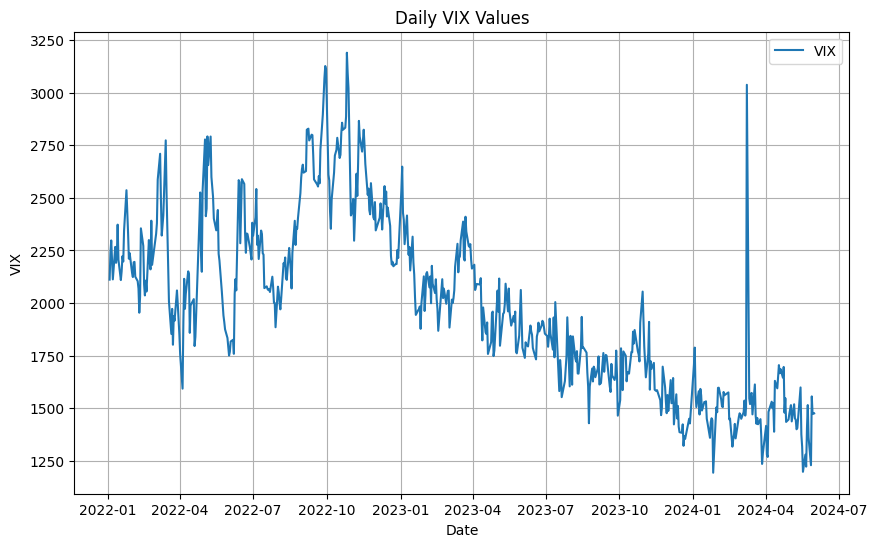

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(vix_df['Date'], vix_df['VIX'], label='VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('Daily VIX Values')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
vix_df

,Date,VIX
0,2022-01-03,2111.023455
1,2022-01-04,2238.409333
2,2022-01-05,2297.307102
3,2022-01-06,2209.453993
4,2022-01-07,2112.226051
...,...,...
578,2024-05-24,1361.854263
579,2024-05-27,1229.369875
580,2024-05-28,1556.349355
581,2024-05-29,1472.529364


In [36]:
import yfinance as yf
# Define the ticker symbol for the IBOV index
ibov_ticker = '^BVSP'  # '^BVSP' is the ticker symbol for the Bovespa Index on Yahoo Finance

# Define the date range for the data
start_date = '2022-01-01'
end_date = '2024-09-01'

# Download historical data
ibov_data = yf.download(ibov_ticker, start=start_date, end=end_date)

# Display the first few rows
# Simplify the column structure
ibov_data.columns = [col[0] for col in ibov_data.columns]  # Take just the first part of each tuple

# Now calculate returns using the simplified column names
adj_close_values = ibov_data['Adj Close']
ibov_data['Log_Returns'] = np.log(adj_close_values / adj_close_values.shift(1))

# Drop the first row with NaN returns
ibov_data = ibov_data.dropna(subset=['Log_Returns'])

[*********************100%***********************]  1 of 1 completed


In [37]:
# Print the column names to see what we're working with
ibov_data

,Adj Close,Close,High,Low,Open,Volume,Log_Returns
Date,,,,,,,
2022-01-04 00:00:00+00:00,103514.0,103514.0,104276.0,103096.0,103922.0,11491600,-0.003934
2022-01-05 00:00:00+00:00,101006.0,101006.0,103514.0,100850.0,103514.0,0,-0.024527
2022-01-06 00:00:00+00:00,101561.0,101561.0,102235.0,101000.0,101006.0,11749200,0.005480
2022-01-07 00:00:00+00:00,102719.0,102719.0,102719.0,101104.0,101561.0,11733200,0.011338
2022-01-10 00:00:00+00:00,101945.0,101945.0,102719.0,101038.0,102719.0,10264700,-0.007564
...,...,...,...,...,...,...,...
2024-08-26 00:00:00+00:00,136889.0,136889.0,137013.0,135596.0,135608.0,7560000,0.009402
2024-08-27 00:00:00+00:00,136776.0,136776.0,137213.0,136664.0,136888.0,6745900,-0.000826
2024-08-28 00:00:00+00:00,137344.0,137344.0,137469.0,135746.0,136776.0,7457100,0.004144


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate daily logarithmic returns
adj_close_values = ibov_data['Adj Close']  # No need to index with ^BVSP since data is already filtered
ibov_data['Log_Returns'] = np.log(adj_close_values / adj_close_values.shift(1))

# Drop the first row with NaN returns
ibov_data = ibov_data.dropna(subset=['Log_Returns'], inplace=False)  # Explicitly set inplace=False


In [49]:
# Shift returns to align future returns with the current date
ibov_data['Future_Log_Returns'] = ibov_data['Log_Returns'].shift(-1)

# Calculate realized volatility over the next 30 days
ibov_data['Realized_Volatility'] = ibov_data['Future_Log_Returns'].rolling(window=14).std() * np.sqrt(252)

# Drop rows with NaN values (these occur at the end due to shifting)
ibov_data.dropna(subset=['Realized_Volatility'], inplace=True)


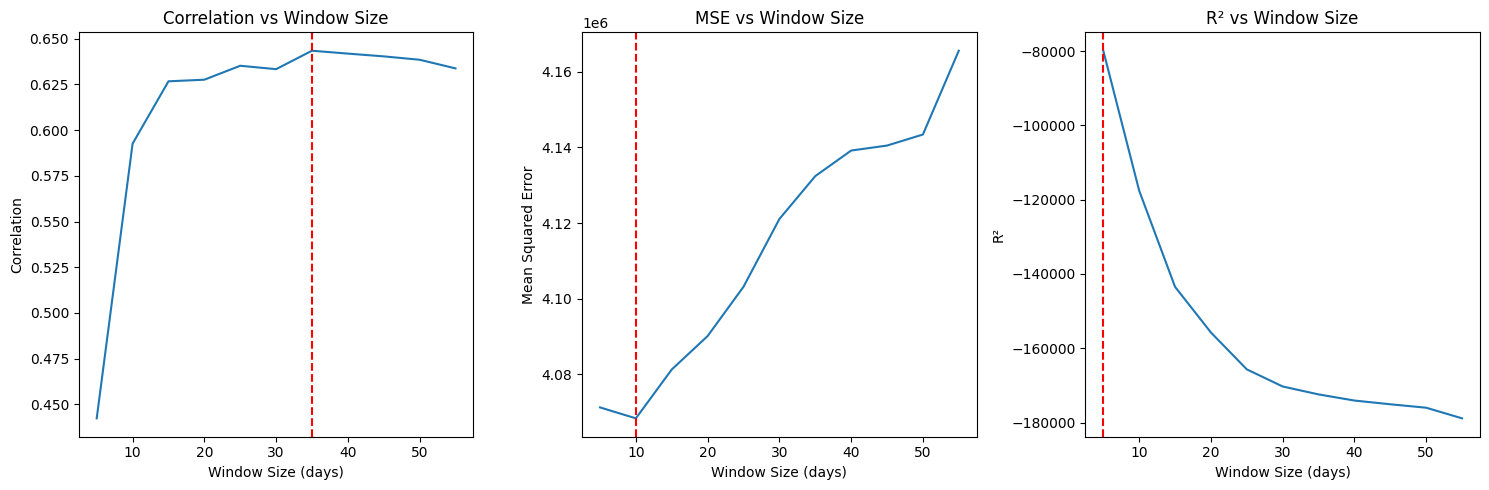


Optimal windows:
Best correlation (0.643): 35.0 days
Best MSE (4068392.778): 10.0 days
Best R² (-79860.729): 5.0 days

Final correlation with 5-day window: 0.576


In [62]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Function to calculate realized volatility for a given window
def calculate_realized_vol(returns, window):
    return returns.rolling(window=window).std() * np.sqrt(252) * 100  # Annualized and scaled to percentage

# Function to calculate correlation and MSE for a given window
def evaluate_window(returns, vix, window):
    # Calculate forward-looking realized volatility
    realized_vol = calculate_realized_vol(returns.shift(-window), window)  # Shift backwards to look forward
    
    # Align VIX and realized volatility data
    data = pd.DataFrame({
        'VIX': vix,
        'Realized_Vol': realized_vol
    }).dropna()
    
    if len(data) < 10:  # Minimum required samples
        return None, None, None
    
    correlation = data['VIX'].corr(data['Realized_Vol'])
    mse = mean_squared_error(data['Realized_Vol'], data['VIX'])
    r2 = r2_score(data['Realized_Vol'], data['VIX'])
    
    return correlation, mse, r2

# Test different windows
windows = range(5, 60, 5)  # Test windows from 5 to 60 days in steps of 5
results = []

for window in windows:
    corr, mse, r2 = evaluate_window(ibov_data['Log_Returns'], vix_df['VIX'], window)
    if corr is not None:
        results.append({
            'Window': window,
            'Correlation': corr,
            'MSE': mse,
            'R2': r2
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find optimal window based on different metrics
best_corr_window = results_df.loc[results_df['Correlation'].abs().idxmax()]
best_mse_window = results_df.loc[results_df['MSE'].idxmin()]
best_r2_window = results_df.loc[results_df['R2'].idxmax()]

# Plot results
plt.figure(figsize=(15, 5))

# Correlation plot
plt.subplot(131)
plt.plot(results_df['Window'], results_df['Correlation'])
plt.axvline(best_corr_window['Window'], color='r', linestyle='--')
plt.title('Correlation vs Window Size')
plt.xlabel('Window Size (days)')
plt.ylabel('Correlation')

# MSE plot
plt.subplot(132)
plt.plot(results_df['Window'], results_df['MSE'])
plt.axvline(best_mse_window['Window'], color='r', linestyle='--')
plt.title('MSE vs Window Size')
plt.xlabel('Window Size (days)')
plt.ylabel('Mean Squared Error')

# R² plot
plt.subplot(133)
plt.plot(results_df['Window'], results_df['R2'])
plt.axvline(best_r2_window['Window'], color='r', linestyle='--')
plt.title('R² vs Window Size')
plt.xlabel('Window Size (days)')
plt.ylabel('R²')

plt.tight_layout()
plt.show()

# Print results
print("\nOptimal windows:")
print(f"Best correlation ({best_corr_window['Correlation']:.3f}): {best_corr_window['Window']} days")
print(f"Best MSE ({best_mse_window['MSE']:.3f}): {best_mse_window['Window']} days")
print(f"Best R² ({best_r2_window['R2']:.3f}): {best_r2_window['Window']} days")

# Use the optimal window (based on R²) to calculate the final realized volatility
optimal_window = int(best_r2_window['Window'])
ibov_data['Realized_Volatility'] = calculate_realized_vol(ibov_data['Log_Returns'].shift(-optimal_window), optimal_window)

# Create final merged dataset with optimal window
merged_df = pd.merge(
    vix_df,
    ibov_data[['Date', 'Realized_Volatility']],
    on='Date',
    how='left'
).dropna()

print(f"\nFinal correlation with {optimal_window}-day window: {merged_df['VIX'].corr(merged_df['Realized_Volatility']):.3f}")

In [70]:
# Convert 'date' columns to datetime
vix_df['Date'] = pd.to_datetime(vix_df['Date'])
ibov_data['Date'] = pd.to_datetime(ibov_data['Date'])

# Merge the VIX DataFrame with the realized volatility DataFrame
merged_df = pd.merge(vix_df, ibov_data[['Date', 'Realized_Volatility']], left_on='Date', right_on='Date', how='left')

# Drop redundant 'Date' column
merged_df.drop(columns=['Date'], inplace=True)
# Drop rows with NaN values in 'VIX' or 'Realized_Volatility'
merged_df.dropna(subset=['VIX', 'Realized_Volatility'], inplace=True)

# Multiply realized volatility by 100 to match VIX scale
merged_df['Realized_Volatility'] *= 50

# Calculate the correlation
correlation = merged_df['VIX'].corr(merged_df['Realized_Volatility'])
print(f"Correlation between VIX and realized volatility: {correlation:.4f}")


Correlation between VIX and realized volatility: 0.5763


## Plot Results

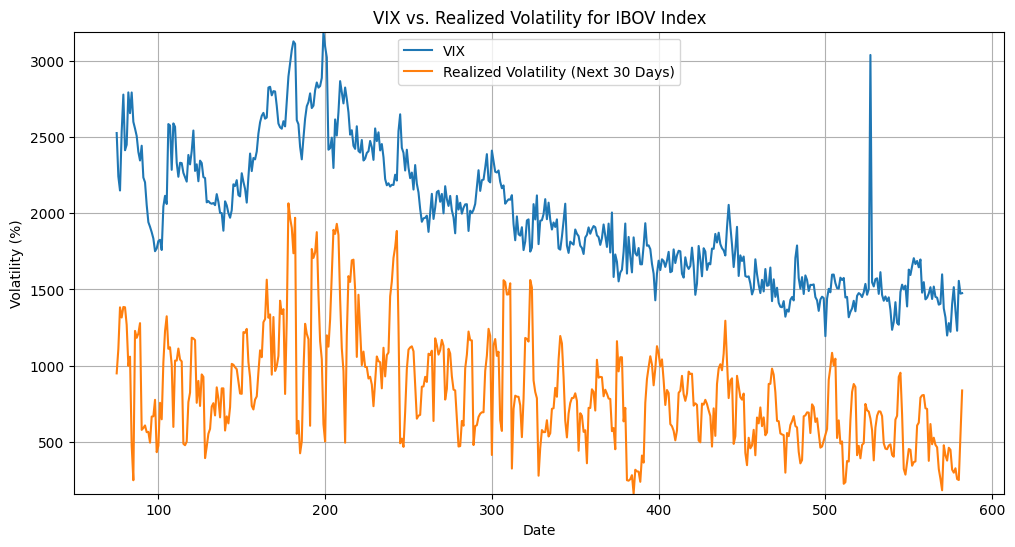

VIX range: 1193.75 to 3189.06
Realized Vol range: 161.20 to 2064.29


In [71]:
# Plot the VIX and realized volatility over time
plt.figure(figsize=(12, 6))

# Use index if Date is the index, or merged_df['date'] if that's the column name
x_values = merged_df.index if 'Date' not in merged_df.columns else merged_df['date']

# Create plot with same y-axis scale
plt.plot(x_values, merged_df['VIX'], label='VIX')
plt.plot(x_values, merged_df['Realized_Volatility'], label='Realized Volatility (Next 30 Days)')

# Set the same scale for both lines
y_min = min(merged_df['VIX'].min(), merged_df['Realized_Volatility'].min())
y_max = max(merged_df['VIX'].max(), merged_df['Realized_Volatility'].max())
plt.ylim(y_min, y_max)

plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.title('VIX vs. Realized Volatility for IBOV Index')
plt.legend()
plt.grid(True)
plt.show()

# Print the range of values for verification
print(f"VIX range: {merged_df['VIX'].min():.2f} to {merged_df['VIX'].max():.2f}")
print(f"Realized Vol range: {merged_df['Realized_Volatility'].min():.2f} to {merged_df['Realized_Volatility'].max():.2f}")

In [32]:
import matplotlib.pyplot as plt  # Changed from 'import matplotlib as plt'

# Scatter plot of VIX vs. Realized Volatility with linear regression line
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['VIX'], merged_df['Realized_Volatility'], alpha=0.6, label='Data Points')

# Calculate linear regression line
m, b = np.polyfit(merged_df['VIX'], merged_df['Realized_Volatility'], 1)
plt.plot(merged_df['VIX'], m*merged_df['VIX'] + b, color='red', label='Linear Regression Line')
plt.xlabel('VIX')
plt.ylabel('Realized Volatility (Next 30 Days)')
plt.title('Scatter Plot of VIX vs. Realized Volatility with Linear Regression Line')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'merged_df' is not defined

<Figure size 800x600 with 0 Axes>

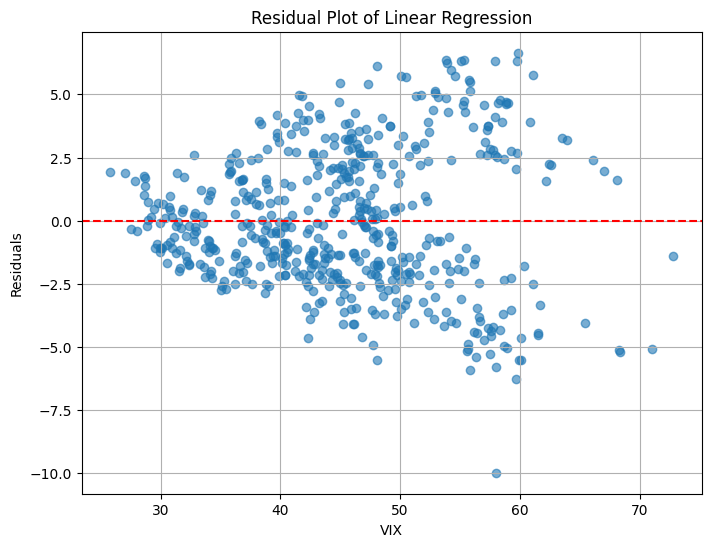

In [113]:
from sklearn.linear_model import LinearRegression

# Prepare data for regression
X = merged_df['VIX'].values.reshape(-1, 1)
y = merged_df['Realized_Volatility'].values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate residuals
residuals = y - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['VIX'], residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('VIX')
plt.ylabel('Residuals')
plt.title('Residual Plot of Linear Regression')
plt.grid(True)
plt.show()


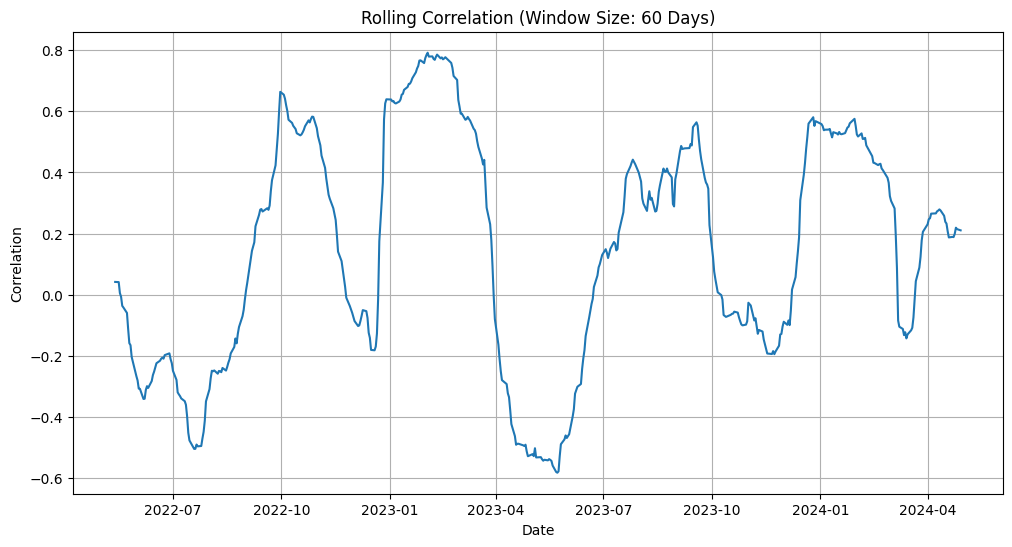

In [114]:
# Calculate rolling correlation with a window of 60 days
window_size = 60
merged_df['Rolling_Correlation'] = merged_df['VIX'].rolling(window=window_size).corr(merged_df['Realized_Volatility'])

# Plot rolling correlation
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['Rolling_Correlation'])
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title(f'Rolling Correlation (Window Size: {window_size} Days)')
plt.grid(True)
plt.show()


/var/folders/cm/s5l2zwms6g332nbkzggv5qnh0000gn/T/ipykernel_7886/154747639.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=merged_df['VIX'], y=merged_df['Realized_Volatility'], cmap="Reds", shade=True, thresh=0)


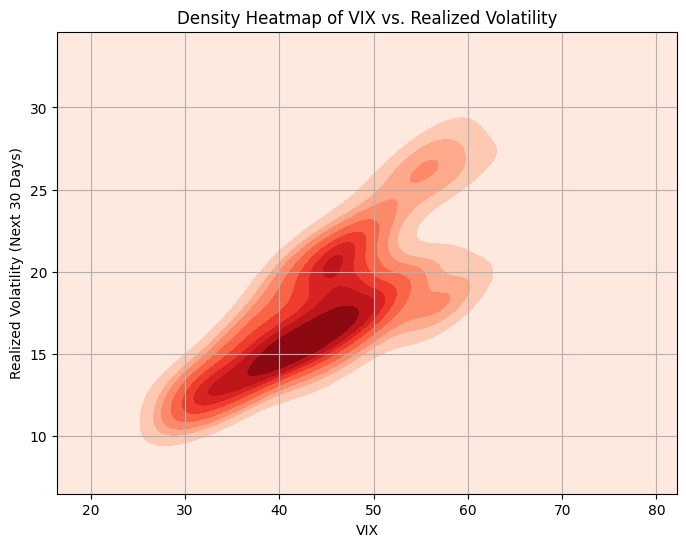

In [116]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.kdeplot(x=merged_df['VIX'], y=merged_df['Realized_Volatility'], cmap="Reds", shade=True, thresh=0)
plt.xlabel('VIX')
plt.ylabel('Realized Volatility (Next 30 Days)')
plt.title('Density Heatmap of VIX vs. Realized Volatility')
plt.grid(True)
plt.show()


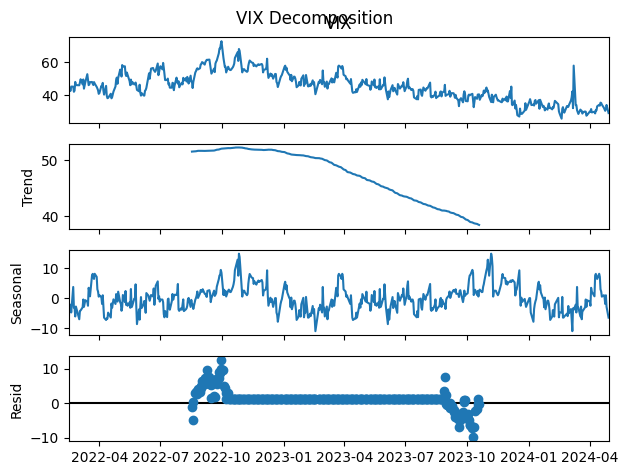

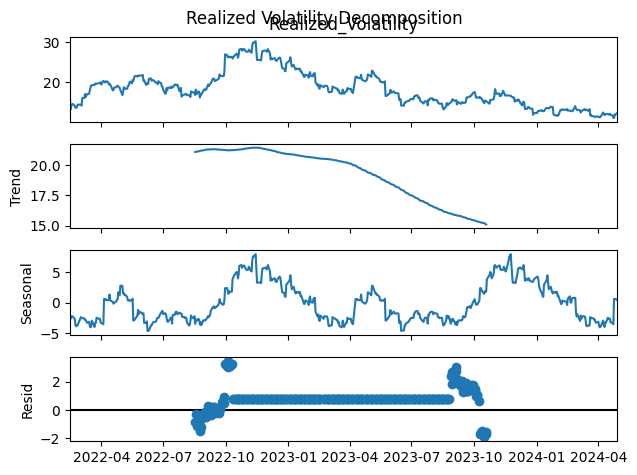

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set 'date' as index
merged_df.set_index('date', inplace=True)

# Perform decomposition
decomposition_vix = seasonal_decompose(merged_df['VIX'], model='additive', period=252)
decomposition_realized_vol = seasonal_decompose(merged_df['Realized_Volatility'], model='additive', period=252)

# Plot the decomposed components for VIX
decomposition_vix.plot()
plt.suptitle('VIX Decomposition')
plt.show()

# Plot the decomposed components for Realized Volatility
decomposition_realized_vol.plot()
plt.suptitle('Realized Volatility Decomposition')
plt.show()

# Reset index if needed
merged_df.reset_index(inplace=True)


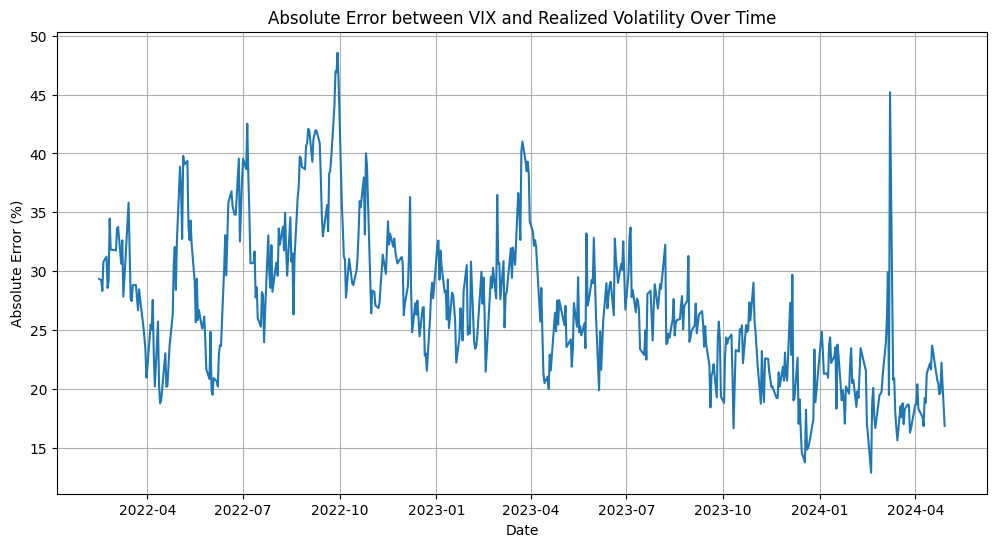

In [118]:
# Calculate absolute errors
merged_df['Absolute_Error'] = abs(merged_df['VIX'] - merged_df['Realized_Volatility'])

# Plot absolute errors over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['Absolute_Error'])
plt.xlabel('Date')
plt.ylabel('Absolute Error (%)')
plt.title('Absolute Error between VIX and Realized Volatility Over Time')
plt.grid(True)
plt.show()


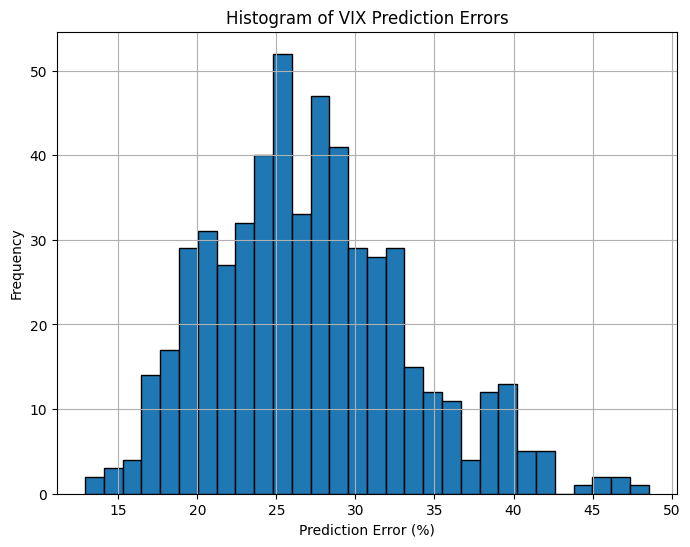

In [119]:
# Plot histogram of errors
plt.figure(figsize=(8, 6))
plt.hist(merged_df['VIX'] - merged_df['Realized_Volatility'], bins=30, edgecolor='black')
plt.xlabel('Prediction Error (%)')
plt.ylabel('Frequency')
plt.title('Histogram of VIX Prediction Errors')
plt.grid(True)
plt.show()


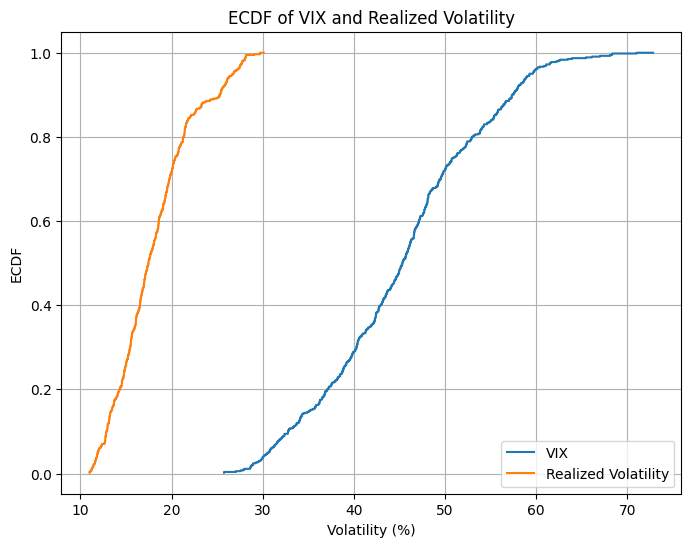

In [120]:
from statsmodels.distributions.empirical_distribution import ECDF

# Calculate ECDFs
ecdf_vix = ECDF(merged_df['VIX'])
ecdf_realized_vol = ECDF(merged_df['Realized_Volatility'])

# Plot ECDFs
plt.figure(figsize=(8, 6))
plt.step(ecdf_vix.x, ecdf_vix.y, label='VIX')
plt.step(ecdf_realized_vol.x, ecdf_realized_vol.y, label='Realized Volatility')
plt.xlabel('Volatility (%)')
plt.ylabel('ECDF')
plt.title('ECDF of VIX and Realized Volatility')
plt.legend()
plt.grid(True)
plt.show()


/var/folders/cm/s5l2zwms6g332nbkzggv5qnh0000gn/T/ipykernel_7886/4144970218.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df['VIX'], shade=True, label='VIX')
/var/folders/cm/s5l2zwms6g332nbkzggv5qnh0000gn/T/ipykernel_7886/4144970218.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df['Realized_Volatility'], shade=True, label='Realized Volatility')


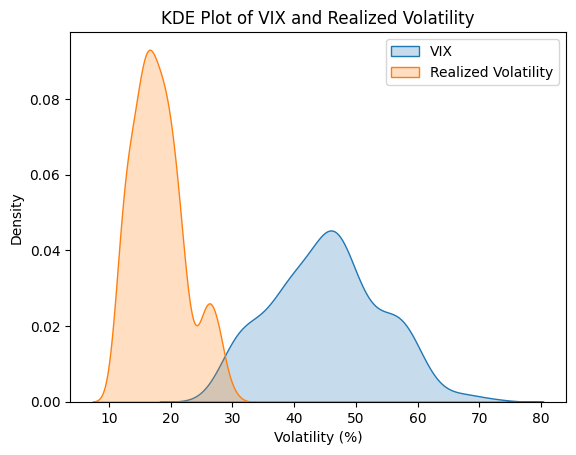

In [121]:
# KDE plot of VIX
sns.kdeplot(merged_df['VIX'], shade=True, label='VIX')

# KDE plot of Realized Volatility
sns.kdeplot(merged_df['Realized_Volatility'], shade=True, label='Realized Volatility')

plt.xlabel('Volatility (%)')
plt.title('KDE Plot of VIX and Realized Volatility')
plt.legend()
plt.show()
